# Analysis of the Termperature of Perth, Australia

The contents of this project are as follows.

1. Objective
2. Introduction to the data
3. Data cleaning 
4. Data exploration and transformations
5. Modeling
6. Modeling conclusions
7. Summary and key findings
8. Suggestions

## Objective

The objective of this project is to use various modeling techniques (such as time series and deep learning) to build a model to describe the temperature patterns of Perth, Australia. The chosen model can be used to make predictions about the future temperature variations as well.

## Introduction to the data

The data was obtained from Kaggle (https://www.kaggle.com/taranmarley/perth-temperatures-and-rainfall). The original data comes from the Australian Bureau of Meteorology and contains temperature and rainfall data measured at Perth airport from 1944 to 2020. The temperature is presented as the daily minimum and maximum in degrees Celsius, while the rainfall is in millimeters.

Following are the features.

1. Year: year of the measurement
2. Month: month of the measurement
3. Day: day of the meaurement
4. Minimum temperature (Degree C)
5. Maximum temperature (Degree C)
6. Rainfall amount (millimetres)
7. Quality: quality of the temperature measurement: binary (yea or no)

Let us load the necessary packages and read in the data.

In [130]:
import numpy as np
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project/PerthTemperatures.csv')

Let us peak into the data.

In [131]:
data.head(3)

,Year,Month,Day,Minimum temperature (Degree C),Maximum temperature (Degree C),Rainfall amount (millimetres),Quality
0,1944.0,6.0,3.0,11.0,22.3,0.0,N
1,1944.0,6.0,4.0,12.2,23.4,0.0,Y
2,1944.0,6.0,5.0,12.0,20.3,2.0,Y


In [132]:
data.dtypes

Year                              float64
Month                             float64
Day                               float64
Minimum temperature (Degree C)    float64
Maximum temperature (Degree C)    float64
Rainfall amount (millimetres)     float64
Quality                            object
dtype: object

Almost all the data is in numeric format and this is very convenient. We do not have to recode the data. 

## Data cleaning

### Long feature names

One problem with the data is the very long feature names. Let us rename them.

In [133]:
tdata = data.rename({'Year': 'year', 'Month': 'month', 'Day': 'day',
                     'Minimum temperature (Degree C)': 'mintemp',
                     'Maximum temperature (Degree C)': 'maxtemp',
                     'Rainfall amount (millimetres)': 'rain',
                     'Quality': 'quality'}, axis=1)

### Unnecessary features

We are only interested in the features related to time and the maximum temperature. Therefore, we can drop all other features.

In [134]:
tdata.drop(columns=['mintemp', 'rain', 'quality'], inplace=True)

### Missing values

Now let us look at missing values.

In [135]:
tdata.isna().sum()

year        1
month       1
day         1
maxtemp    31
dtype: int64

In [136]:
tdata[tdata.year.isna()]

,year,month,day,maxtemp
27646,NaN,NaN,NaN,NaN


This observation lacks all the necessary data. Therefore, let us drop it.

In [137]:
tdata.drop(index=27646, inplace=True)

For the missing *maxtemp* values, we can carry out a linear interpolation.

In [138]:
tdata.maxtemp.interpolate(inplace=True)

### Floats into integers

Let us convert float date features into integers because they are easier to be handled.

In [139]:
tdata.year = tdata.year.astype(int)
tdata.month = tdata.month.astype(int)
tdata.day = tdata.day.astype(int)

In [140]:
tdata.dtypes

year         int64
month        int64
day          int64
maxtemp    float64
dtype: object

### Forming a single date feature

Presently, the data contains three features for year, month, and day. We shall coalesce them into a single date feature.

In [141]:
from datetime import date

tdata['date'] = tdata.apply(lambda row: date(year = int(row['year']),
                                             month = int(row['month']),
                                             day = int(row['day'])), axis=1)

### Resetting the index

We need the index to be above formed *date* feature.

In [142]:
tdata.set_index(tdata.date, inplace=True)

### Truncation

The data set is too large for this study. Therefore, we will truncate the data set to include only data between 2010 and 2019.

*tdata20* set is for predictions and it includes data for the year 2020.

In [143]:
temp = tdata[tdata.date > date(2010,1,1)]

tdata = temp[temp.date < date(2019,1,1)]
tdata20 = temp[temp.date > date(2019,1,1)]

## Data exploration and transformations
 
### Stationarity

Following is a run sequence plot of the data.

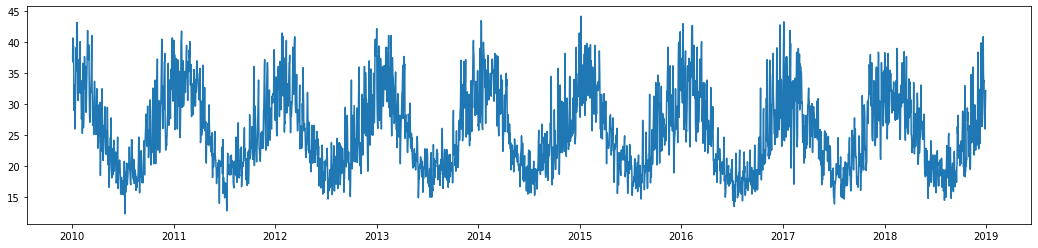

In [144]:
import matplotlib
import matplotlib.pyplot as plt

plt.plot(tdata.date, tdata.maxtemp)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18,4)

As above figure is not very clear, let us plot a subset.

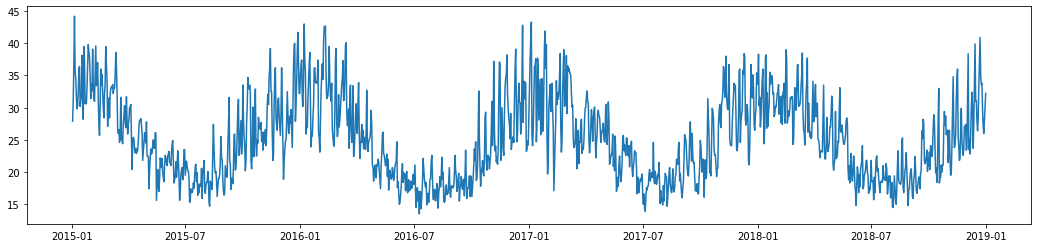

In [145]:
temp = tdata[tdata.date > date(2015,1,1)]
temp = temp[temp.date < date(2020,1,1)]

plt.plot(temp.date, temp.maxtemp)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18,4)

We can see that the data **does not** have a trend i.e. the mean seems to be constant. However, seasonality is **present**.

Let us split data into chunks and calculate test statistics mean and variance.

In [146]:
chunks = np.array_split(tdata.maxtemp, indices_or_sections=5)

print("{} | {:7} | {}".format("Chunk", "Mean", "Variance"))
print("-" * 26)
for i, chunk in enumerate(chunks, 1):
    print("{:5} | {:.5} | {:.5}".format(i, np.mean(chunk), np.var(chunk)))

Chunk | Mean    | Variance
--------------------------
    1 | 25.792 | 45.07
    2 | 26.024 | 39.438
    3 | 26.286 | 37.027
    4 | 24.994 | 45.07
    5 | 24.485 | 32.185


Both values above seem to be nearly constant. Therefore, we can state that the data has a **constant mean** and **homoscedastic**.

Non stationary data results in a uniform distribution for its histogram. Let us check this.

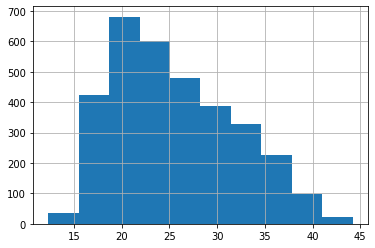

In [147]:
tdata.maxtemp.hist();

Above histogram is a nearly normal one with a right skew. This again points to **stationarity**.

Let us carry out augmented Dickey-Fuller test on the data.

In [148]:
from statsmodels.tsa.stattools import adfuller

adf, pvalue, _, _, _, _ = adfuller(tdata.maxtemp)

print("ADF value: {:.2f} \nP-value: {:.2E}".format(adf, pvalue))

ADF value: -3.44 
P-value: 9.53E-03


With such a small p-value, we can reject the null hypothesis that the data is non stationary.

From all of the above tests, it is clear that the data is **stationary**.

### Seasonality

From the second run series plot, it is clear that the data set has some seasonality. Let us explore this further.

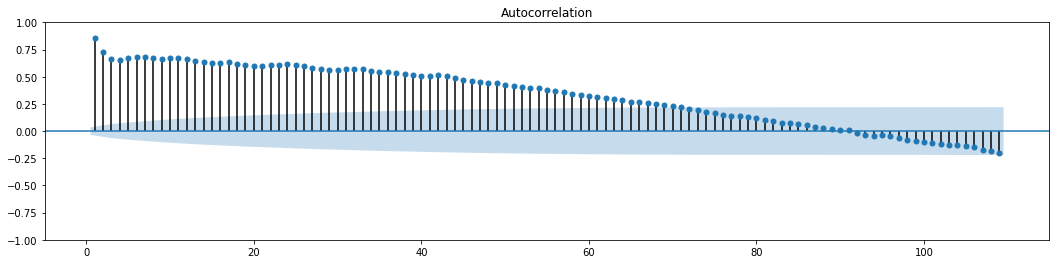

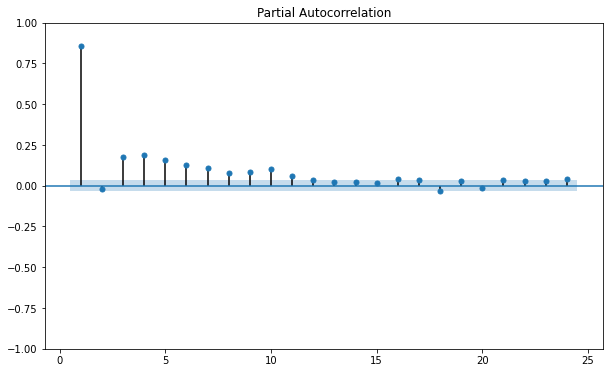

In [149]:
import statsmodels.api as sm

sm.tsa.graphics.plot_acf(tdata.maxtemp, lags=range(1,110));
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18,4)

sm.tsa.graphics.plot_pacf(tdata.maxtemp, lags=range(1,25));
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10,6)


The ACF plot shows strong autocorrelations within the data set. This is strong evidence for seasonality. 

## Modeling

From above plots, ACF plot appears to decay very slowly, indicating that an AR model is the most suitable. The *p* parameter appears to be 1. 

Following models will be tested.

1. ARMA with p = 1 and q = 0
2. ARMA with p = 10 and q = 0
2. Hyper parameter optimization of a SARIMA model using pmdarima.auto_arima

### Model 1

This is the model with only the AR component with *p* = 1.

In [150]:
model1 = sm.tsa.ARIMA(tdata.maxtemp, order=(1,0,0), freq='D').fit()

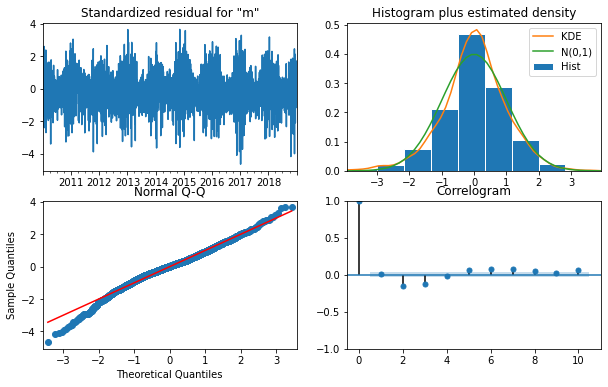

In [152]:
model1.plot_diagnostics();
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10,6)

### Model 2

This model is an AR model with *p* = 10. This is highly likely to be overfit.

In [153]:
model2 = sm.tsa.ARIMA(tdata.maxtemp, order=(10,0,0), freq='D').fit()

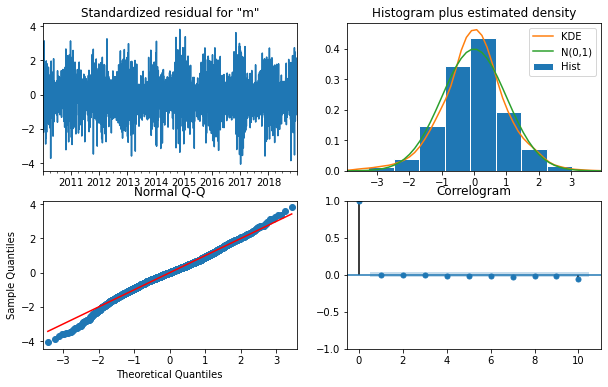

In [154]:
model2.plot_diagnostics();
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10,6)

### Model 3

In this model, we use a grid search to find the best parameters for the ARIMA model including the seasonality.

In [155]:
import pmdarima as pm

In [156]:
model3 = pm.auto_arima(tdata.maxtemp, start_p=1, start_q=1,
                        max_p=5, max_q=5, m=7, start_P=0, seasonal=True,
                        d=0, D=1, trace=False, maxiter=25,
                        error_action='warn', method='nm',  
                        suppress_warnings=True, stepwise=True)

The values of *p*, and *q* are as follows.

In [157]:
ord = model3.to_dict()['order']

print('p = {}\nd = {}\nq = {}'.format(ord[0], ord[1], ord[2]))

p = 2
d = 0
q = 0


The seasonal *P*, *D*, and *Q* are as follows.

In [158]:
sord = model3.to_dict()['seasonal_order']

print('P = {}\nD = {}\nQ = {}'.format(sord[0], sord[1], sord[2]))

P = 0
D = 1
Q = 2


Model diagnostics are given below.

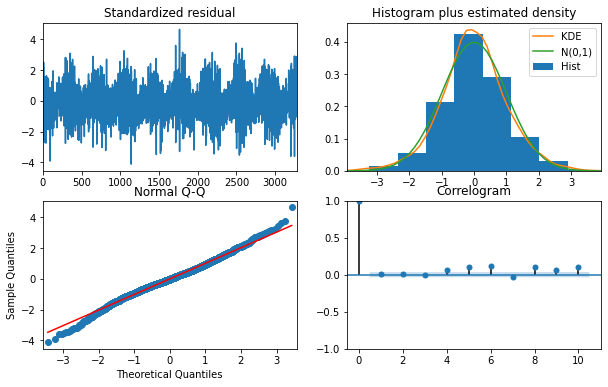

In [159]:
model3.plot_diagnostics();
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10,6)

SARIMA model based on above determined parameters is created below.

In [160]:
m3 = sm.tsa.statespace.SARIMAX(tdata.maxtemp, 
                                order=(2,0,0), 
                                seasonal_order=(0,1,2,7), 
                                trend='c', freq='D').fit()

## Model performance

In this section, we shall look into the performance of the models in predicting future behavior of the data.

### Model 1

The training set as well as the predictions made using the model are plotted below. The plot also includes a confidence interval for the mean of the predictions.

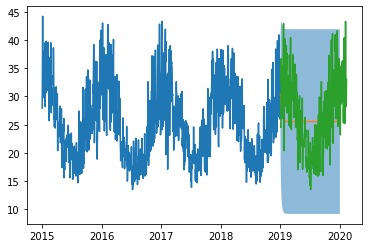

In [161]:
# Predictions for the next year.
m1_future = model1.get_forecast(365)
m1_ci = m1_future.conf_int(alpha = 0.01)

# Same as above. The above doesn't yield individual points.
# Therefore, we need this.
m1pred = model1.predict(start=date(2019,1,2), end=date(2020,1,1))

# For clarity, plot starting from 2015.
plt.plot(tdata[tdata.date > date(2015,1,1)].maxtemp)

plt.plot(m1pred)
plt.fill_between(m1_ci.index, m1_ci['lower maxtemp'], m1_ci['upper maxtemp'],
                 alpha = 0.5)

plt.plot(tdata20.maxtemp);

### Model 2

Same plots as above.


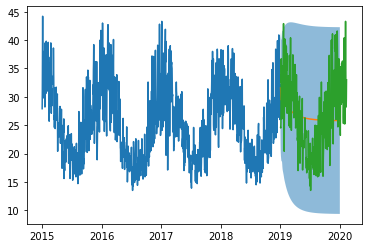

In [162]:
m2_future = model2.get_forecast(365) 
m2_ci = m2_future.conf_int(alpha = 0.01)

m2pred = model2.predict(start=date(2019,1,2), end=date(2020,1,1))

plt.plot(tdata[tdata.date > date(2015,1,1)].maxtemp)

plt.plot(m2pred)
plt.fill_between(m2_ci.index, m2_ci['lower maxtemp'], m2_ci['upper maxtemp'], 
                 alpha = 0.5)

plt.plot(tdata20.maxtemp);

### Model 3


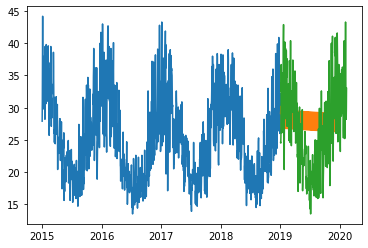

In [163]:
# Prediction
m3pred = m3.predict(start=date(2019,1,2), end=date(2020,1,1))

# Plot
plt.plot(tdata[tdata.date > date(2015,1,1)].maxtemp)
plt.plot(m3pred)
plt.plot(tdata20.maxtemp);

## Summary and key findings

All three models did not result in satisfactory outcomes. However, the third one, where we performed a grid search, resulted in a somewhat better model than the previous ones. As this involves hyper parameter searching, this method should be used for best results.

After a careful look at the dataset and the documentation of the packages used, it appears that missing dates in the dataset can cause problems in the modeling. As some of the dates are missing in the dataset, this might be the problem that caused poor modeling.

## Suggestions

Using a complete dataset without any dates missing is recommendable for a better modeling exercise. Furthermore, if this is not possible (usually the case with historical datasets), it is better to look at the mean monthly maximum temperature at the dependent variable. In this case, missing data are not possible.

Use of modeling methods which are resilient to such problems are also a solution.

It is possible that the problems faced are something entirely different. In this case, we need to look deep at each step to identify the root cause of poor results.